In [1]:
# Latihan 1
# import library pandas
import pandas as pd

# Import library numpy
import numpy as np

# Import library matplotlib dan seaborn untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

# me-non aktifkan peringatan pada python
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Latihan 2
# Panggil file (load file bernama Iris_AfterClean.csv) dan simpan dalam dataframe Lalu tampilkan 5 baris awal dataset dengan function head()
df = pd.read_csv("Iris_AfterClean.csv")
df.head(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,4.6,3.1,1.5,0.2,Iris-setosa
1,5.0,3.6,1.4,0.2,Iris-setosa
2,5.4,3.9,1.7,0.4,Iris-setosa
3,4.9,3.1,1.5,0.1,Iris-setosa
4,5.4,3.7,1.5,0.2,Iris-setosa


In [3]:
# Melihat Informasi lebih detail mengenai struktur DataFrame dapat dilihat menggunakan fungsi info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  140 non-null    float64
 1   SepalWidthCm   140 non-null    float64
 2   PetalLengthCm  140 non-null    float64
 3   PetalWidthCm   140 non-null    float64
 4   Species        140 non-null    object 
dtypes: float64(4), object(1)
memory usage: 5.6+ KB


In [4]:
# melihat statistik data untuk data numeric seperti count, mean, standard deviation, maximum, mininum, dan quartile.
df.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,140.000000,140.000000,140.000000,140.000000
mean,5.902857,3.028571,3.910714,1.262857
std,0.819365,0.398791,1.720369,0.746825
min,4.300000,2.200000,1.000000,0.100000
25%,5.200000,2.800000,1.675000,0.400000
50%,5.850000,3.000000,4.500000,1.400000
75%,6.425000,3.300000,5.100000,1.800000
max,7.900000,4.000000,6.900000,2.500000


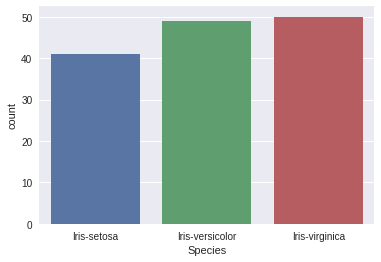

In [5]:
# Latihan 3
# Melihat distribusi data dari target classes --> Species
sns.countplot(df['Species'])

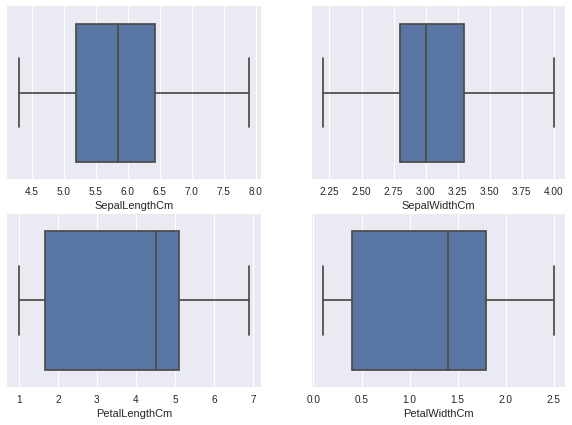

In [6]:
# Plotting boxplots untuk memeriksa distribusi kolom numerik
cols = df.columns[:-1].tolist()
fig,ax = plt.subplots(2,2,figsize=(10,7))
r = c = 0
for col in cols:
  sns.boxplot(x=col, data=df,ax=ax[r,c])
  if c == 1:
    r+=1
    c = 0
    continue
  c+=1

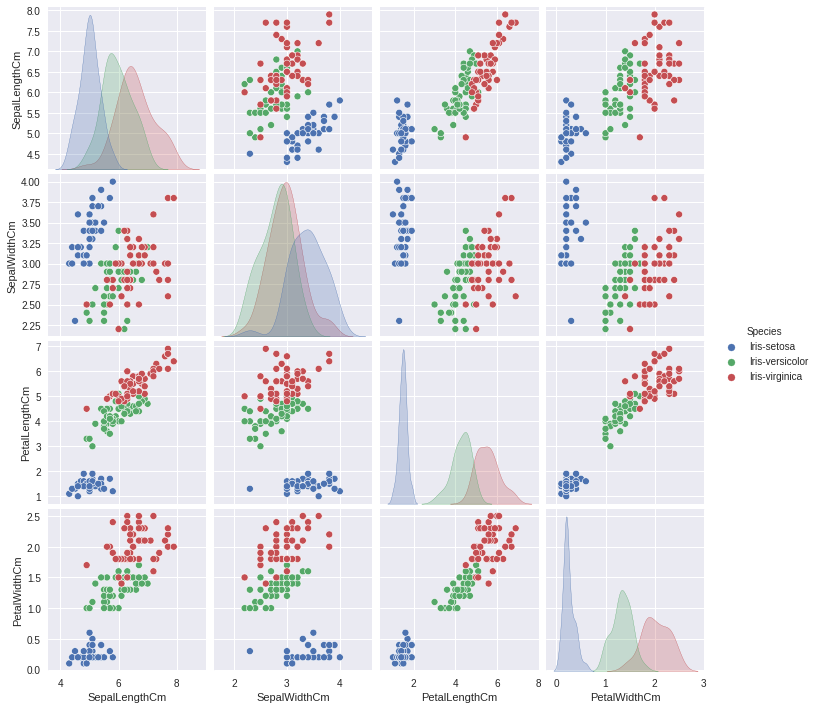

In [7]:
# visualisasikan kolom numerik yang dikelompokkan berdasarkan spesies
sns.pairplot(df,hue='Species')

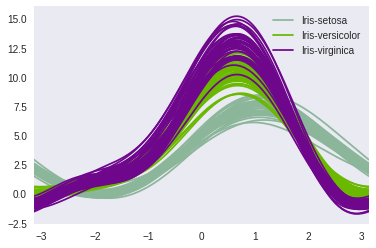

In [8]:
'''
Satu teknik pandas yang lebih canggih dan keren telah tersedia disebut Andrews Curves.
Kurva Andrews melibatkan penggunaan atribut sampel sebagai koefisien untuk deret Fourier
dan kemudian mem plotting ini
'''

from pandas.plotting import andrews_curves
andrews_curves(df, "Species")

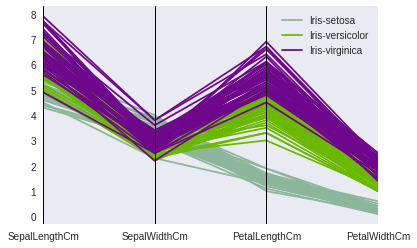

In [9]:
'''
Teknik visualisasi multivariat lain yang dimiliki pandas adalah parallel_coordinates.
Koordinat paralel memplot setiap fitur pada kolom terpisah & kemudian menggambar garis
menghubungkan fitur untuk setiap sampel data
'''

from pandas.plotting import parallel_coordinates
parallel_coordinates(df, "Species")

In [10]:
# Latihan 4
# definisi variabel X / data feature dan y / data targer (species):
X = df.drop('Species',axis=1).values

# Karena ini adalah klasifikasi multikelas, label keluaran dikodekan satu kali untuk melatih ANN
y = pd.get_dummies(df['Species']).values

In [11]:
# split data train dan test dengan function train_test_split() dengan train_size=0.7, test_size=0.25 dan random_state=101

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X,y,test_size=0.25,random_state=101)

In [12]:
# Latihan 5
# lakukan penskalaan min-maks
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Latihan 6
# Import library pada keras yang dibutuhkan
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [14]:
# input_shape
X_train_scaled.shape[1:]

(4,)

In [15]:
def build_model(n_hidden = 1, n_neurons=5, learning_rate=3e-3, input_shape=X_train_scaled.shape[1:]):
  '''
  Membangun keras ANN untuk Klasifikasi Multiclass yaitu kelas keluaran yang saling eksklusif
  ''' 

  model = Sequential()
  options = {"input_shape": input_shape}


  # Menambahkan input dan hidden layers
  for layer in range(n_hidden):
    model.add(Dense(n_neurons,activation="relu",**options))
    options = {}
    
    
  # Menambahkan output layer yang memiliki 3 neuron, 1 per kelas 
  model.add(Dense(3,activation='softmax'))
    
    
  # Membuat instance adam optimizer
  opt = Adam(learning_rate=learning_rate)
  model.compile(optimizer=opt,loss='categorical_crossentropy',metrics='accuracy')
  return model

In [16]:
# Menerapkan KerasClassifier Wrapper ke neural network
keras_cls = KerasClassifier(build_model)

In [17]:
# Latihan 7
# import library EarlyStopping dan RandomizedSearchCV

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV

In [18]:
param_dict = {
    "n_hidden" : (2,3),
    "n_neurons" : tuple(range(2,7)),
    "learning_rate" : (3e-2,3e-3,3e-4)
}

model_cv = RandomizedSearchCV(keras_cls, param_dict, n_iter=10, cv=3)

In [19]:
%%time
model_cv.fit(
    X_train_scaled, y_train, epochs=150,
    validation_data = (X_test_scaled,y_test),
    callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)],
    verbose=0
)

2/2 [==============================] - 0s 5ms/step - loss: 0.1247 - accuracy: 0.9429
CPU times: user 1min 36s, sys: 3.38 s, total: 1min 39s
Wall time: 1min 42s


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fbea066aa10>,
                   param_distributions={'learning_rate': (0.03, 0.003, 0.0003),
                                        'n_hidden': (2, 3),
                                        'n_neurons': (2, 3, 4, 5, 6)})

In [20]:
model_cv.best_params_

{'learning_rate': 0.03, 'n_hidden': 3, 'n_neurons': 6}

In [21]:
model_cv.best_score_

0.9333333373069763

In [22]:
# Latihan 8
# building model based on best set of parameters obtained from RandomSearchCV
best_set = model_cv.best_params_

model = build_model(learning_rate= best_set['learning_rate'], 
                    n_hidden= best_set['n_hidden'], n_neurons= best_set['n_neurons'])

In [23]:
model.fit(
    X_train_scaled, y_train, epochs=100,
    validation_data = (X_test_scaled,y_test),
    callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=10)],
    verbose=0
)

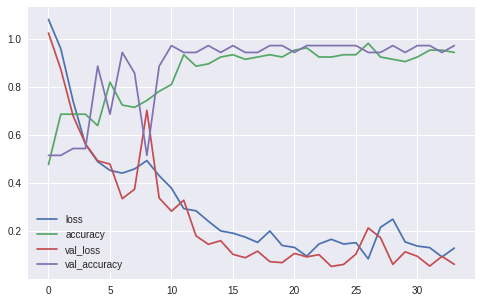

In [24]:
# Latihan 9
pd.DataFrame(model.history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [25]:
# Latihan 10
from sklearn.metrics import classification_report,confusion_matrix

# Instead of probabilities it provides class labels
pred_classes = model_cv.predict(X_test_scaled)
y_test_classes = np.argmax(y_test,axis=1)
print(classification_report(y_test_classes,pred_classes),"\n\n")
print(confusion_matrix(y_test_classes,pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.94      0.97        16
           2       0.91      1.00      0.95        10

    accuracy                           0.97        35
   macro avg       0.97      0.98      0.97        35
weighted avg       0.97      0.97      0.97        35
 


[[ 9  0  0]
 [ 0 15  1]
 [ 0  0 10]]
